### Combining GRACE mascon and LIS model output

In [110]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
sys.path.append('../../scripts')

from branca.colormap import linear
import folium

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import pyepsg
import scipy.optimize
from shapely.geometry import (Polygon, Point, box)
import xarray as xr
import regionmask

from dask.diagnostics import ProgressBar
    
from GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, get_cmwe_trend_analysis)
from LIS import utils as LISutils

In [12]:
Linux = False
if Linux:
   fname = '/att/nobackup/aarendt/GRACE/GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
   datadir = '/att/nobackup/aarendt/LIS/'
else:
   fname = 'c:\work\datadrive\GRACE\GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
   datadir = "c:\\work\\datadrive\\LIS\\"

In [3]:
fpath = os.path.join(os.path.abspath(os.path.curdir), fname)

In [4]:
f = extract_grace(fpath)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [5]:
mascon = f['mascon']

In [6]:
mascon_gdf = get_mascon_gdf(mascon)

There are 41168 Mascons in this dataset.


In [7]:
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

## read in the natural Earth dataset

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## build a polygon representing HMA bounding box

In [ ]:
coordinates = [(62,26), (62,46), (106,46), (106, 26)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

### bring in the LIS data

### Import the monthly average LIS product I calculated in [LIS Notebook](https://github.com/NASA-Planetary-Science/HiMAT/blob/master/Projects/LIS/waterBalance.ipynb) and stored temporarily on nobackup

* calculate the water balance from all the components

In [13]:
ds = xr.open_mfdataset(datadir + '*.nc')
ds = ds.chunk({'time': 1})

In [14]:
ds

<xarray.Dataset>
Dimensions:     (east_west: 1896, north_south: 1696, time: 180)
Coordinates:
    longitude   (north_south, east_west) float64 66.03 66.04 66.05 66.06 ...
    latitude    (north_south, east_west) float64 22.02 22.02 22.02 22.02 ...
  * time        (time) datetime64[ns] 2001-01-01 2001-02-01 2001-03-01 ...
Dimensions without coordinates: east_west, north_south
Data variables:
    Evap_tavg   (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...
    Rainf_tavg  (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...
    Qs_tavg     (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...
    Snowf_tavg  (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...
    Qsm_tavg    (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...
    Qsb_tavg    (time, north_south, east_west) float64 0.0 0.0 0.0 0.0 0.0 ...

### Build a polygon around the extent of the LIS output so we can subset the GRACE data

In [28]:
# getting the max/min lat/lon from the LIS dataset
minLong = ds.coords['longitude'].min().values
maxLong = ds.coords['longitude'].max().values
minLat = ds.coords['latitude'].min().values
maxLat = ds.coords['latitude'].max().values

coordinates = [(minLong,minLat), (minLong,maxLat), (maxLong,maxLat), (maxLong, minLat)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

../../scripts\GRACE_MASCON\pygrace.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  mascon_gdf['avg_mass_change_cm'] = avg_mass


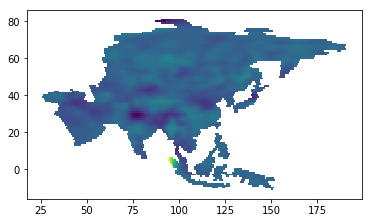

In [29]:
# HMA
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]
HMA_w_trend = get_cmwe_trend_analysis(HMA, f)
HMA_w_trend.plot(column='avg_mass_change_cm')

### Select only those mascons in the HMA bounding box

In [30]:
gpd_intersect = gpd.overlay(HMA_region, HMA_w_trend, how='intersection')

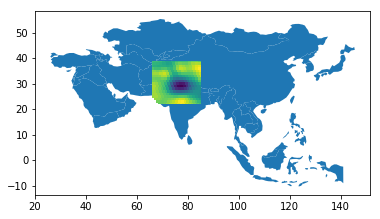

In [31]:
gpd_intersect.plot(column='avg_mass_change_cm', ax=world[world['continent'] == 'Asia'].plot(), figsize=(20, 20));

### build a mask into the LIS coordinates based on the GRACE mascons 
* using [regionmask](http://regionmask.readthedocs.io/en/stable/)

In [32]:
numbers = gpd_intersect.index.values
names = gpd_intersect['mascon'].values
abbrevs = gpd_intersect['mascon'].values
m = regionmask.Regions_cls('HMA_msk',numbers,names,abbrevs,gpd_intersect.geometry.values)

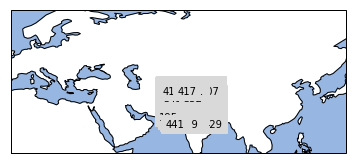

In [33]:
ax = m.plot()
import cartopy.crs as ccrs
ax.set_extent([0, 140, 10, 70], crs = ccrs.PlateCarree());

In [34]:
m.name = 'mascon'

### this builds the mask 
* we can do this for just one variable and one time slice, since all the lat/long grids are coregistered anyhow
* this takes some time

In [36]:
t = xr.open_dataset(datadir + 'snowMonthly.nc')
m2 = m.mask(t['Snowf_tavg'].isel(time=0), lon_name = 'longitude', lat_name = 'latitude')
# print('All NaN? ', np.all(np.isnan(m2)))

In [82]:
m2.name = 'mask'

<xarray.DataArray 'mask' (north_south: 1696, east_west: 1896)>
array([[  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,  429.,  429.,   nan],
       [  nan,   nan,   nan, ...,  429.,  429.,   nan],
       ..., 
       [  nan,  228.,  228., ...,  249.,  249.,   nan],
       [  nan,  228.,  228., ...,  249.,  249.,   nan],
       [  nan,  228.,  228., ...,  249.,  249.,   nan]])
Coordinates:
  * north_south  (north_south) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * east_west    (east_west) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    latitude     (north_south, east_west) float64 22.02 22.02 22.02 22.02 ...
    longitude    (north_south, east_west) float64 66.03 66.04 66.05 66.06 ...

In [99]:
# serialize for later
#m2.to_netcdf(datadir + 'gracemsk.nc')
m2 = xr.open_dataset(datadir + 'gracemsk.nc')

In [100]:
m2

<xarray.Dataset>
Dimensions:      (east_west: 1896, north_south: 1696)
Coordinates:
  * north_south  (north_south) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * east_west    (east_west) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    latitude     (north_south, east_west) float64 22.02 22.02 22.02 22.02 ...
    longitude    (north_south, east_west) float64 66.03 66.04 66.05 66.06 ...
Data variables:
    mask         (north_south, east_west) float64 nan nan nan nan nan nan ...

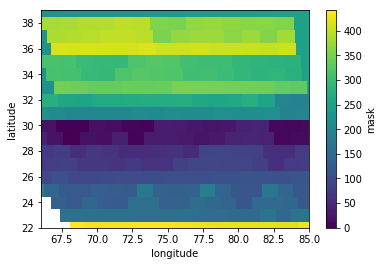

In [101]:
m2['mask'].plot(x='longitude',y='latitude')

In [22]:
with ProgressBar():
    df = ds.where(m2['m2'] == 100).groupby('time').sum().to_dataframe()

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed | 13.2s
[########################################] | 100% Completed | 13.0s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 14.2s
[########################################] | 100% Completed | 12.2s
[########################################] | 100% Completed | 12.7s


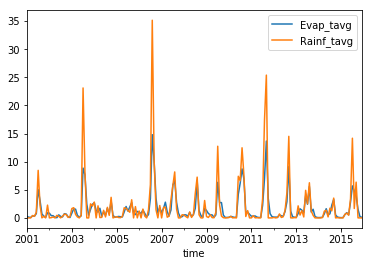

In [21]:
df[['Evap_tavg','Rainf_tavg']].plot()

In [23]:
waterbal = df['Rainf_tavg'] + df['Snowf_tavg'] - df['Qsb_tavg'] - df['Qsb_tavg'] - df['Qsm_tavg'] - df['Evap_tavg']

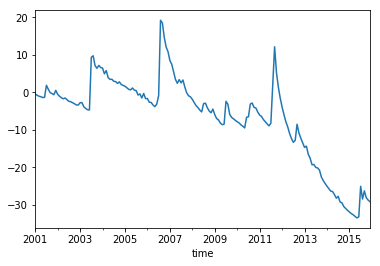

In [25]:
waterbal.cumsum().plot()

In [104]:
## get the mascon time series

mc = names[numbers == 100][0]


8040

In [107]:
soln = f['solution']